In [22]:
from utils.train import GAN
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
from sklearn.metrics import mean_squared_error

In [27]:
target2ckpt = {
    'Google': 'lightning_logs/version_46/checkpoints/epoch=852-step=18766.ckpt',
    'Apple': 'lightning_logs/version_51/checkpoints/epoch=916-step=20174.ckpt',
    'Amazon': 'lightning_logs/version_48/checkpoints/epoch=639-step=14080.ckpt',
    'Microsoft': 'lightning_logs/version_49/checkpoints/epoch=593-step=13068.ckpt',
}

In [28]:
target = 'Microsoft'
ckpt_path = target2ckpt[target]
model = GAN.load_from_checkpoint(ckpt_path)
model.eval()
model.freeze()
X, Y = model.dataset[:]
y_pred = model(X.to(model.device))
y_true = model.raw_dataset.y_scaler.inverse_transform(Y[:, model.num_days_for_predict].cpu()).flatten()
y_pred = model.raw_dataset.y_scaler.inverse_transform(y_pred.cpu()).flatten()

In [25]:
split = int(len(y_pred)*0.8)
y_train_pred, y_test_pred = y_pred[:split], y_pred[split:]
y_train, y_test = y_true[:split], y_true[split:]
train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)
test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
standard_RMSE = mean_squared_error(y_true[1:], y_true[:-1], squared=False)
train_standard_RMSE = mean_squared_error(y_train[1:], y_train[:-1], squared=False)
test_standard_RMSE = mean_squared_error(y_test[1:], y_test[:-1], squared=False)
print('target:', target)
print("train RMSE:", train_RMSE)
print("test RMSE:", test_RMSE)
print("standard RMSE:", standard_RMSE)
print("train standard RMSE:", train_standard_RMSE)
print("test standard RMSE:", test_standard_RMSE)
print("train RMSE / standard RMSE:", train_RMSE/train_standard_RMSE)
print("test RMSE / standard RMSE:", test_RMSE/test_standard_RMSE)


target: Microsoft
train RMSE: 4.967184274429996
test RMSE: 18.113539564030454
standard RMSE: 4.141635704900756
train standard RMSE: 3.76580099347588
test standard RMSE: 5.380564938732131
train RMSE / standard RMSE: 1.3190246332813313
test RMSE / standard RMSE: 3.36647541109293


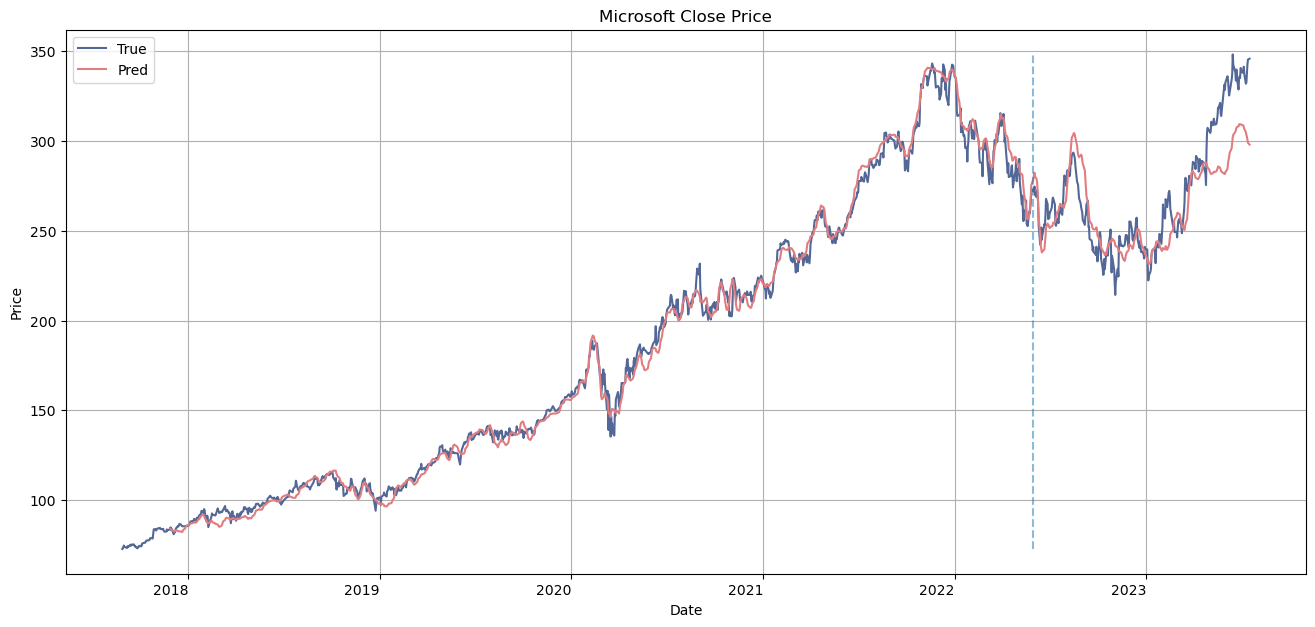

In [26]:
df = model.raw_dataset.df
df[f'{target} Close Pred'] = None
df.iloc[-len(y_pred):, -1] = y_pred
df[f'{target} Close'].plot(figsize=(16,8),label=f'True', color='#536897')
df[f'{target} Close Pred'].plot(figsize=(16,8),label=f'Pred', color='#E17D81', rot=0)

split = df.index[int(len(df) * model.hparams.train_size)]
plt.plot((split, split), (df[f'{target} Close'].min(), df[f'{target} Close'].max()), linestyle='--', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{target} Close Price')
plt.savefig(f'images/{target} Close Price Prediction.png', dpi=300, bbox_inches='tight')